In [1]:
import numpy as np

In [2]:
class Modelisation:
    def __init__(self, matrix, model) -> None:
        # matrice du modèle MCEE
        self.A = matrix["A"]
        self.B = matrix["B"]
        self.C = matrix["C"]
        self.D = matrix["D"]
        

In [16]:
# calcul des moments d'inertie du dirigeable
# --> ellipsoïde

a = 3
b = 0.75
c = 0.75

mass_d = 3

I_x = (1/5) * mass_d * (np.square(b) + np.square(c))
I_y = (1/5) * mass_d * (np.square(a) + np.square(c))
I_z = (1/5) * mass_d * (np.square(a) + np.square(b))
print(f"Le moment d'intertie autour de x est : {round(I_x, 4)}, celui autour de y est : {round(I_y, 4)} et celui autour de z est : {round(I_z, 4)}")

Le moment d'intertie autour de x est : 0.675, celui autour de y est : 5.7375 et celui autour de z est : 5.7375


In [31]:
# calcul des distances entre le CG des composants et le CG du dirigeable

CG_dir = np.array([0.39706, 0, -0.098039])
CG_AvD = np.array([2, 0.8, 0])
CG_AvG = np.array([2, -0.8, 0])
CG_ArD = np.array([-2, 0.8, 0])
CG_ArG = np.array([-2, -0.8, 0])
CG_Nac = np.array([0, 0, -0.8])

d_AvD_GC = np.linalg.norm(CG_dir - CG_AvD)
d_AvG_GC = np.linalg.norm(CG_dir - CG_AvG)
d_ArD_GC = np.linalg.norm(CG_dir - CG_ArD)
d_ArG_GC = np.linalg.norm(CG_dir - CG_ArG)
d_Nac_GC = np.linalg.norm(CG_dir - CG_Nac)

print(f"Distance entre AvD/CG_dir : {round(d_AvD_GC, 5)}")
print(f"Distance entre AvG/CG_dir : {round(d_AvG_GC, 5)}")
print(f"Distance entre ArD/CG_dir : {round(d_ArD_GC, 5)}")
print(f"Distance entre ArG/CG_dir : {round(d_ArG_GC, 5)}")
print(f"Distance entre Nac/CG_dir : {round(d_Nac_GC, 5)}")

dist_vect = np.array([d_AvD_GC, d_AvG_GC, d_ArD_GC, d_ArG_GC, d_Nac_GC])

Distance entre AvD/CG_dir : 1.79417
Distance entre AvG/CG_dir : 1.79417
Distance entre ArD/CG_dir : 2.52893
Distance entre ArG/CG_dir : 2.52893
Distance entre Nac/CG_dir : 0.80648


Erreur lors du calcul de LQR: 
The n-th order system of linear algebraic
equations, from which the solution matrix X would
be obtained, is singular to working precision.
(8, 6)
L'erreur est la suivante :  shapes (8,) and (4,) not aligned: 8 (dim 0) != 4 (dim 0)


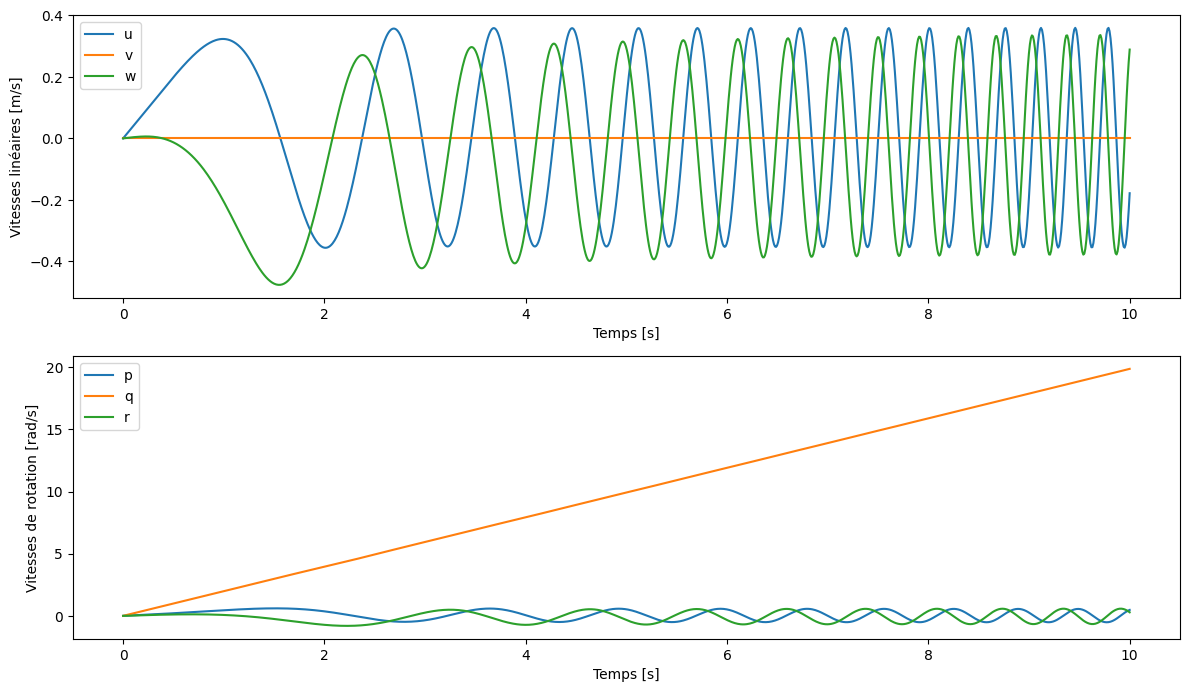

In [24]:
import numpy as np
import control
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Paramètres du système
m = 100.0  # masse (kg)
I_x = 360.0  # moment d'inertie autour de x (kg.m^2)
I_y = 4680.0  # moment d'inertie autour de y (kg.m^2)
I_z = 4680.0  # moment d'inertie autour de z (kg.m^2)
d = 1.0  # distance des moteurs au centre de gravité (m)
g = 9.81  # gravité (m/s^2)

# Force de flottabilité
F_b = m * g  # Supposons que la flottabilité équilibre exactement le poids

# Matrices d'état (linéarisées autour d'un point d'équilibre)
A = np.array([
    [0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, (I_y - I_z) / I_x, 0],
    [0, 0, 0, 0, 0, (I_z - I_x) / I_y],
    [0, 0, 0, (I_x - I_y) / I_z, 0, 0]
])

# Matrice d'entrée B
B = np.zeros((6, 4))
B[0, :] = [1/m, 1/m, 1/m, 1/m]  # Contributions des forces T_i à l'accélération en x
B[2, :] = [1/m, 1/m, 1/m, 1/m]  # Contributions des forces T_i à l'accélération en z
B[3, :] = [d/I_x, d/I_x, d/I_x, d/I_x]  # Contributions des forces T_i aux moments autour de x
B[4, :] = [d/I_y, d/I_y, d/I_y, d/I_y]  # Contributions des forces T_i aux moments autour de y
B[5, :] = [d/I_z, d/I_z, d/I_z, d/I_z]  # Contributions des forces T_i aux moments autour de z

# Matrices de coût LQR (Q, R)
Q = np.eye(6)
R = np.eye(4)

# Calcul du gain LQR
try:
    K, S, E = control.lqr(A, B, Q, R)
except Exception as e:
    print(f"Erreur lors du calcul de LQR: {e}")

# Simulation du système avec rétroaction d'état
def dynamics(t, state, K):
    X = state
    U = -K @ X  # Application correcte de la rétroaction d'état
    
    # Angles des moteurs (fixes ou dynamiques, exemple ici, fixés à 90 degrés)
    alpha1, alpha2, alpha3, alpha4 = np.radians(90), np.radians(90), np.radians(90), np.radians(90)

    # Forces et moments calculés en utilisant les entrées variables
    F_x = np.dot(U, np.array([np.cos(alpha1), np.cos(alpha2), np.cos(alpha3), np.cos(alpha4)]))
    F_z = np.dot(U, np.array([np.sin(alpha1), np.sin(alpha2), np.sin(alpha3), np.sin(alpha4)])) - m * g + F_b
    tau_x = np.dot(U, np.array([d*np.sin(alpha1), d*np.sin(alpha2), d*np.sin(alpha3), d*np.sin(alpha4)]))
    tau_y = np.dot(U, np.array([d*np.cos(alpha1), d*np.cos(alpha2), d*np.cos(alpha3), d*np.cos(alpha4)]))
    tau_z = np.dot(U, np.array([d*np.sin(alpha1), d*np.sin(alpha2), d*np.sin(alpha3), d*np.sin(alpha4)]))
    
    # Équations de mouvement avec termes de Coriolis
    u, v, w, p, q, r = X
    u_dot = F_x / m - r * v + q * w
    v_dot = 0  # simplification
    w_dot = F_z / m - q * u + p * v
    p_dot = tau_x / I_x + (I_y - I_z) / I_x * q * r
    q_dot = tau_y / I_y + (I_z - I_x) / I_y * p * r
    r_dot = tau_z / I_z + (I_x - I_y) / I_z * p * q
    
    return [u_dot, v_dot, w_dot, p_dot, q_dot, r_dot]

# Conditions initiales
X0 = np.array([0, 0, 0, 0, 0, 0])  # état initial

# Temps de simulation
t_span = (0, 10)  # 10 secondes de simulation
t_eval = np.linspace(t_span[0], t_span[1], 1000)

# Simulation
if 'K' in locals():
    print(K.shape)
    try:
        sol = solve_ivp(dynamics, t_span, X0, args=(K,), t_eval=t_eval)
    except Exception as error:
        print("L'erreur est la suivante : ", error )
        
    

    # Extraction des résultats
    u = sol.y[0]
    v = sol.y[1]
    w = sol.y[2]
    p = sol.y[3]
    q = sol.y[4]
    r = sol.y[5]

    # Tracé des résultats
    plt.figure(figsize=(12, 10))

    # Tracé des vitesses linéaires
    plt.subplot(3, 1, 1)
    plt.plot(sol.t, u, label='u')
    plt.plot(sol.t, v, label='v')
    plt.plot(sol.t, w, label='w')
    plt.xlabel('Temps [s]')
    plt.ylabel('Vitesses linéaires [m/s]')
    plt.legend()

    # Tracé des vitesses de rotation
    plt.subplot(3, 1, 2)
    plt.plot(sol.t, p, label='p')
    plt.plot(sol.t, q, label='q')
    plt.plot(sol.t, r, label='r')
    plt.xlabel('Temps [s]')
    plt.ylabel('Vitesses de rotation [rad/s]')
    plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print("Impossible de calculer le LQR, vérifier les matrices A et B.")


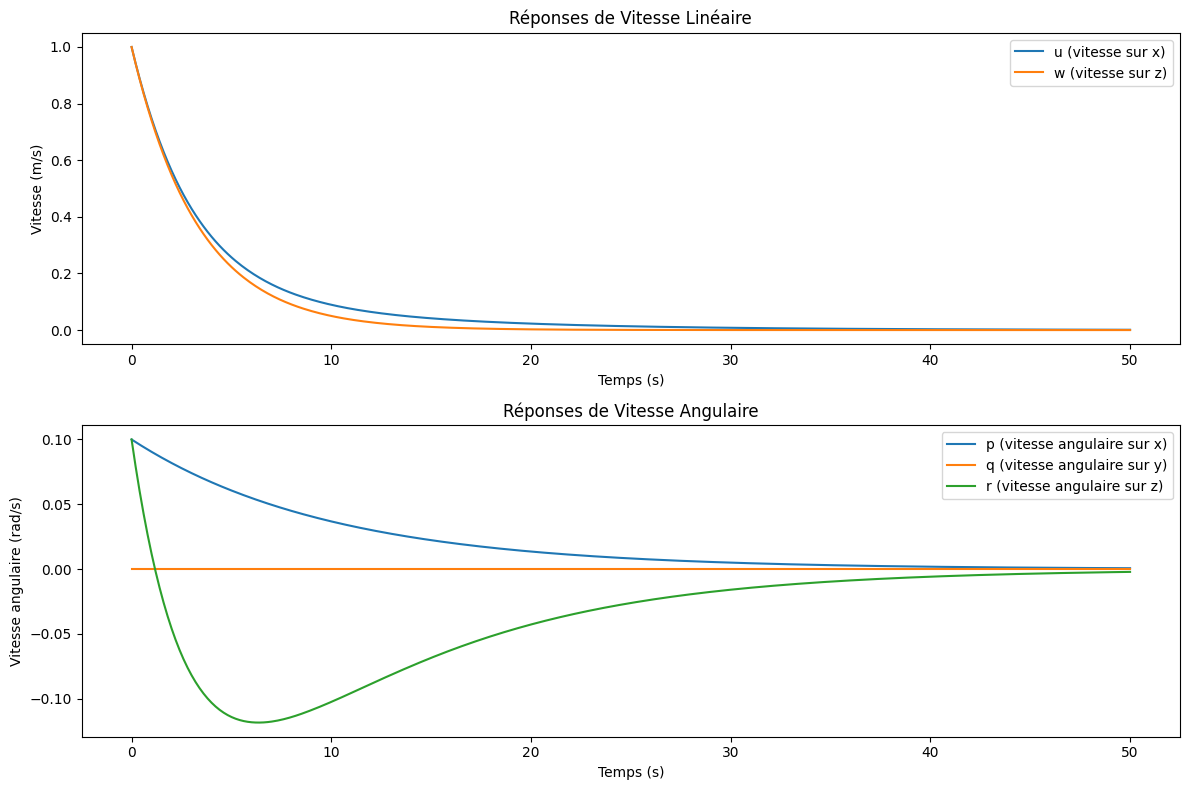

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_continuous_are, expm
from scipy.integrate import solve_ivp

# Constantes du système
A = np.array([
    [-0.1, 0, 0, 0, 0, 0],
    [0, -0.1, 0, 0, 0, 0],
    [0, 0, -0.1, 0, 0, 0],
    [0, 0, 0, -0.1, 0, 0],
    [0, 0, 0, 0, -0.1, 0],
    [0, 0, 0, 0, 0, -0.1]
])

B = np.array([
    [0.1, 0, 0.1, 0, 0.1, 0, 0.1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0.1, 0, 0.1, 0, 0.1, 0, 0.1],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0.05, 0, 0.05, 0, 0.05, 0, 0.05, 0]
])

Q = np.diag([1, 1, 1, 1, 1, 1])
R = np.diag([0.5] * 8)

P = solve_continuous_are(A, B, Q, R)
K = np.linalg.inv(R) @ (B.T @ P)

# Fonction de simulation
def dirigeable_dynamics(t, X):
    return (A - B @ K) @ X

# Conditions initiales
X0 = [1, 0, 1, 0.1, 0, 0.1]  # Un peu de vitesse initiale et de vitesse angulaire

# Résolution du système
sol = solve_ivp(dirigeable_dynamics, [0, 50], X0, t_eval=np.linspace(0, 50, 500))

# Affichage des résultats
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(sol.t, sol.y[0], label='u (vitesse sur x)')
plt.plot(sol.t, sol.y[2], label='w (vitesse sur z)')
plt.title('Réponses de Vitesse Linéaire')
plt.xlabel('Temps (s)')
plt.ylabel('Vitesse (m/s)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(sol.t, sol.y[3], label='p (vitesse angulaire sur x)')
plt.plot(sol.t, sol.y[4], label='q (vitesse angulaire sur y)')
plt.plot(sol.t, sol.y[5], label='r (vitesse angulaire sur z)')
plt.title('Réponses de Vitesse Angulaire')
plt.xlabel('Temps (s)')
plt.ylabel('Vitesse angulaire (rad/s)')
plt.legend()

plt.tight_layout()
plt.show()


In [36]:
import sympy as sp

# Définir les variables d'état
u, v, w, p, q, r = sp.symbols('u v w p q r')
u0, v0, w0, p0, q0, r0 = sp.symbols('u0 v0 w0 p0 q0 r0')
delta_u, delta_v, delta_w, delta_p, delta_q, delta_r = sp.symbols('delta_u delta_v delta_w delta_p delta_q delta_r')

# Masse et moment d'inertie
m = 1.0  # Ex: 1 kg
I = 1.0  # Ex: 1 kg.m^2

# Définir les forces de Coriolis linéarisées
F_coriolis_u = 2 * m * (r * v - q * w)
F_coriolis_v = 2 * m * (p * w - r * u)
F_coriolis_w = 2 * m * (q * u - p * v)

# Substituer les perturbations
F_coriolis_u = F_coriolis_u.subs({u: u0 + delta_u, v: v0 + delta_v, w: w0 + delta_w, p: p0 + delta_p, q: q0 + delta_q, r: r0 + delta_r})
F_coriolis_v = F_coriolis_v.subs({u: u0 + delta_u, v: v0 + delta_v, w: w0 + delta_w, p: p0 + delta_p, q: q0 + delta_q, r: r0 + delta_r})
F_coriolis_w = F_coriolis_w.subs({u: u0 + delta_u, v: v0 + delta_v, w: w0 + delta_w, p: p0 + delta_p, q: q0 + delta_q, r: r0 + delta_r})

# Développer et linéariser
F_coriolis_u = sp.expand(F_coriolis_u)
F_coriolis_v = sp.expand(F_coriolis_v)
F_coriolis_w = sp.expand(F_coriolis_w)

# Termes d'équilibre (constantes)
equilibrium_terms_u = F_coriolis_u.subs({delta_u: 0, delta_v: 0, delta_w: 0, delta_p: 0, delta_q: 0, delta_r: 0})
equilibrium_terms_v = F_coriolis_v.subs({delta_u: 0, delta_v: 0, delta_w: 0, delta_p: 0, delta_q: 0, delta_r: 0})
equilibrium_terms_w = F_coriolis_w.subs({delta_u: 0, delta_v: 0, delta_w: 0, delta_p: 0, delta_q: 0, delta_r: 0})

# Perturbations (linéarisation)
F_coriolis_u_linearized = F_coriolis_u - equilibrium_terms_u
F_coriolis_v_linearized = F_coriolis_v - equilibrium_terms_v
F_coriolis_w_linearized = F_coriolis_w - equilibrium_terms_w

# Calculer les dérivées partielles pour former la matrice A (forces)
A11 = sp.diff(F_coriolis_u_linearized, delta_u)
A12 = sp.diff(F_coriolis_u_linearized, delta_v)
A13 = sp.diff(F_coriolis_u_linearized, delta_w)
A14 = sp.diff(F_coriolis_u_linearized, delta_p)
A15 = sp.diff(F_coriolis_u_linearized, delta_q)
A16 = sp.diff(F_coriolis_u_linearized, delta_r)

A21 = sp.diff(F_coriolis_v_linearized, delta_u)
A22 = sp.diff(F_coriolis_v_linearized, delta_v)
A23 = sp.diff(F_coriolis_v_linearized, delta_w)
A24 = sp.diff(F_coriolis_v_linearized, delta_p)
A25 = sp.diff(F_coriolis_v_linearized, delta_q)
A26 = sp.diff(F_coriolis_v_linearized, delta_r)

A31 = sp.diff(F_coriolis_w_linearized, delta_u)
A32 = sp.diff(F_coriolis_w_linearized, delta_v)
A33 = sp.diff(F_coriolis_w_linearized, delta_w)
A34 = sp.diff(F_coriolis_w_linearized, delta_p)
A35 = sp.diff(F_coriolis_w_linearized, delta_q)
A36 = sp.diff(F_coriolis_w_linearized, delta_r)

# Moment equations (assume similar process for rotation)
# For simplicity, let's assume the inertia terms are similar in form to the mass terms
# This is an approximation, and specific moments of inertia should be used for more accurate modeling

# For a simplified model, we can use the same Coriolis terms:
M_coriolis_p = F_coriolis_u
M_coriolis_q = F_coriolis_v
M_coriolis_r = F_coriolis_w

# Linearize moment equations (similar process)
M_coriolis_p_linearized = F_coriolis_u_linearized
M_coriolis_q_linearized = F_coriolis_v_linearized
M_coriolis_r_linearized = F_coriolis_w_linearized

A41 = sp.diff(M_coriolis_p_linearized, delta_u)
A42 = sp.diff(M_coriolis_p_linearized, delta_v)
A43 = sp.diff(M_coriolis_p_linearized, delta_w)
A44 = sp.diff(M_coriolis_p_linearized, delta_p)
A45 = sp.diff(M_coriolis_p_linearized, delta_q)
A46 = sp.diff(M_coriolis_p_linearized, delta_r)

A51 = sp.diff(M_coriolis_q_linearized, delta_u)
A52 = sp.diff(M_coriolis_q_linearized, delta_v)
A53 = sp.diff(M_coriolis_q_linearized, delta_w)
A54 = sp.diff(M_coriolis_q_linearized, delta_p)
A55 = sp.diff(M_coriolis_q_linearized, delta_q)
A56 = sp.diff(M_coriolis_q_linearized, delta_r)

A61 = sp.diff(M_coriolis_r_linearized, delta_u)
A62 = sp.diff(M_coriolis_r_linearized, delta_v)
A63 = sp.diff(M_coriolis_r_linearized, delta_w)
A64 = sp.diff(M_coriolis_r_linearized, delta_p)
A65 = sp.diff(M_coriolis_r_linearized, delta_q)
A66 = sp.diff(M_coriolis_r_linearized, delta_r)

# Construire la matrice A
A = sp.Matrix([
    [A11, A12, A13, A14, A15, A16],
    [A21, A22, A23, A24, A25, A26],
    [A31, A32, A33, A34, A35, A36],
    [A41, A42, A43, A44, A45, A46],
    [A51, A52, A53, A54, A55, A56],
    [A61, A62, A63, A64, A65, A66]
])

# Valeurs d'équilibre spécifiques (exemple)
equilibrium_values = {
    u0: 1.0,
    v0: 0.0,
    w0: 0.0,
    p0: 0.0,
    q0: 0.0,
    r0: 0.1
}

# Évaluer la matrice A avec les valeurs numériques
A_numeric = A.subs(equilibrium_values)
A_numeric


Matrix([
[                 0, 2.0*delta_r + 0.2, -2.0*delta_q,            0,      -2.0*delta_w,        2.0*delta_v],
[-2.0*delta_r - 0.2,                 0,  2.0*delta_p,  2.0*delta_w,                 0, -2.0*delta_u - 2.0],
[       2.0*delta_q,      -2.0*delta_p,            0, -2.0*delta_v, 2.0*delta_u + 2.0,                  0],
[                 0, 2.0*delta_r + 0.2, -2.0*delta_q,            0,      -2.0*delta_w,        2.0*delta_v],
[-2.0*delta_r - 0.2,                 0,  2.0*delta_p,  2.0*delta_w,                 0, -2.0*delta_u - 2.0],
[       2.0*delta_q,      -2.0*delta_p,            0, -2.0*delta_v, 2.0*delta_u + 2.0,                  0]])

In [38]:
import sympy as sp

# Définir les variables d'état
u, v, w, p, q, r = sp.symbols('u v w p q r')
u0, v0, w0, p0, q0, r0 = sp.symbols('u0 v0 w0 p0 q0 r0')
delta_u, delta_v, delta_w, delta_p, delta_q, delta_r = sp.symbols('delta_u delta_v delta_w delta_p delta_q delta_r')

# Masse et moment d'inertie
m = sp.symbols('m')
I = sp.symbols('I')

# Définir la tension comme variable d'entrée
V = sp.symbols('V')
V0 = sp.symbols('V0')
delta_V = sp.symbols('delta_V')

# Définir la force de poussée des moteurs
f_norm = 0.048 * V**2 - 0.011 * V + 0.009

# Substituer les perturbations de la tension
f_norm = f_norm.subs({V: V0 + delta_V})
f_norm = sp.expand(f_norm)

# Termes d'équilibre (constantes) pour la poussée
equilibrium_term_f_norm = f_norm.subs({delta_V: 0})

# Perturbations (linéarisation) pour la poussée
f_norm_linearized = f_norm - equilibrium_term_f_norm

# Définir les forces de Coriolis linéarisées
F_coriolis_u = 2 * m * (r * v - q * w)
F_coriolis_v = 2 * m * (p * w - r * u)
F_coriolis_w = 2 * m * (q * u - p * v)

# Substituer les perturbations
F_coriolis_u = F_coriolis_u.subs({u: u0 + delta_u, v: v0 + delta_v, w: w0 + delta_w, p: p0 + delta_p, q: q0 + delta_q, r: r0 + delta_r})
F_coriolis_v = F_coriolis_v.subs({u: u0 + delta_u, v: v0 + delta_v, w: w0 + delta_w, p: p0 + delta_p, q: q0 + delta_q, r: r0 + delta_r})
F_coriolis_w = F_coriolis_w.subs({u: u0 + delta_u, v: v0 + delta_v, w: w0 + delta_w, p: p0 + delta_p, q: q0 + delta_q, r: r0 + delta_r})

# Développer et linéariser
F_coriolis_u = sp.expand(F_coriolis_u)
F_coriolis_v = sp.expand(F_coriolis_v)
F_coriolis_w = sp.expand(F_coriolis_w)

# Termes d'équilibre (constantes) pour les forces de Coriolis
equilibrium_terms_u = F_coriolis_u.subs({delta_u: 0, delta_v: 0, delta_w: 0, delta_p: 0, delta_q: 0, delta_r: 0})
equilibrium_terms_v = F_coriolis_v.subs({delta_u: 0, delta_v: 0, delta_w: 0, delta_p: 0, delta_q: 0, delta_r: 0})
equilibrium_terms_w = F_coriolis_w.subs({delta_u: 0, delta_v: 0, delta_w: 0, delta_p: 0, delta_q: 0, delta_r: 0})

# Perturbations (linéarisation) pour les forces de Coriolis
F_coriolis_u_linearized = F_coriolis_u - equilibrium_terms_u
F_coriolis_v_linearized = F_coriolis_v - equilibrium_terms_v
F_coriolis_w_linearized = F_coriolis_w - equilibrium_terms_w

# Ajouter la force de poussée linéarisée aux équations
F_u_total = F_coriolis_u_linearized + f_norm_linearized
F_v_total = F_coriolis_v_linearized  # Pas de contribution directe de la poussée dans v
F_w_total = F_coriolis_w_linearized  # Pas de contribution directe de la poussée dans w

# Calculer les dérivées partielles pour former la matrice A (forces)
A11 = sp.diff(F_u_total, delta_u)
A12 = sp.diff(F_u_total, delta_v)
A13 = sp.diff(F_u_total, delta_w)
A14 = sp.diff(F_u_total, delta_p)
A15 = sp.diff(F_u_total, delta_q)
A16 = sp.diff(F_u_total, delta_r)

A21 = sp.diff(F_v_total, delta_u)
A22 = sp.diff(F_v_total, delta_v)
A23 = sp.diff(F_v_total, delta_w)
A24 = sp.diff(F_v_total, delta_p)
A25 = sp.diff(F_v_total, delta_q)
A26 = sp.diff(F_v_total, delta_r)

A31 = sp.diff(F_w_total, delta_u)
A32 = sp.diff(F_w_total, delta_v)
A33 = sp.diff(F_w_total, delta_w)
A34 = sp.diff(F_w_total, delta_p)
A35 = sp.diff(F_w_total, delta_q)
A36 = sp.diff(F_w_total, delta_r)

# Moment equations (assume similar process for rotation)
# For simplicity, let's assume the inertia terms are similar in form to the mass terms
# This is an approximation, and specific moments of inertia should be used for more accurate modeling

# For a simplified model, we can use the same Coriolis terms:
M_coriolis_p = F_coriolis_u
M_coriolis_q = F_coriolis_v
M_coriolis_r = F_coriolis_w

# Linearize moment equations (similar process)
M_coriolis_p_linearized = F_coriolis_u_linearized
M_coriolis_q_linearized = F_coriolis_v_linearized
M_coriolis_r_linearized = F_coriolis_w_linearized

A41 = sp.diff(M_coriolis_p_linearized, delta_u)
A42 = sp.diff(M_coriolis_p_linearized, delta_v)
A43 = sp.diff(M_coriolis_p_linearized, delta_w)
A44 = sp.diff(M_coriolis_p_linearized, delta_p)
A45 = sp.diff(M_coriolis_p_linearized, delta_q)
A46 = sp.diff(M_coriolis_p_linearized, delta_r)

A51 = sp.diff(M_coriolis_q_linearized, delta_u)
A52 = sp.diff(M_coriolis_q_linearized, delta_v)
A53 = sp.diff(M_coriolis_q_linearized, delta_w)
A54 = sp.diff(M_coriolis_q_linearized, delta_p)
A55 = sp.diff(M_coriolis_q_linearized, delta_q)
A56 = sp.diff(M_coriolis_q_linearized, delta_r)

A61 = sp.diff(M_coriolis_r_linearized, delta_u)
A62 = sp.diff(M_coriolis_r_linearized, delta_v)
A63 = sp.diff(M_coriolis_r_linearized, delta_w)
A64 = sp.diff(M_coriolis_r_linearized, delta_p)
A65 = sp.diff(M_coriolis_r_linearized, delta_q)
A66 = sp.diff(M_coriolis_r_linearized, delta_r)

# Construire la matrice A
A = sp.Matrix([
    [A11, A12, A13, A14, A15, A16],
    [A21, A22, A23, A24, A25, A26],
    [A31, A32, A33, A34, A35, A36],
    [A41, A42, A43, A44, A45, A46],
    [A51, A52, A53, A54, A55, A56],
    [A61, A62, A63, A64, A65, A66]
])

# Valeurs d'équilibre spécifiques (exemple)
equilibrium_values = {
    u0: 1.0,
    v0: 0.0,
    w0: 0.0,
    p0: 0.0,
    q0: 0.0,
    r0: 0.1,
    V0: 3.0  # Ex: tension d'équilibre de 3V
}

# Évaluer la matrice A avec les valeurs numériques
A_numeric = A.subs(equilibrium_values)
A_numeric = A_numeric.subs(m, 1.0)  # Exemple de substitution pour m
A_numeric = A_numeric.subs(I, 1.0)  # Exemple de substitution pour I

# Afficher la matrice numérique A
sp.pprint(A_numeric)


⎡      0        2.0⋅δᵣ + 0.2  -2.0⋅δ_q     0       -2.0⋅δ_w       2.0⋅δᵥ    ⎤
⎢                                                                           ⎥
⎢-2.0⋅δᵣ - 0.2       0         2.0⋅δₚ   2.0⋅δ_w       0        -2.0⋅δᵤ - 2.0⎥
⎢                                                                           ⎥
⎢   2.0⋅δ_q       -2.0⋅δₚ        0      -2.0⋅δᵥ  2.0⋅δᵤ + 2.0        0      ⎥
⎢                                                                           ⎥
⎢      0        2.0⋅δᵣ + 0.2  -2.0⋅δ_q     0       -2.0⋅δ_w       2.0⋅δᵥ    ⎥
⎢                                                                           ⎥
⎢-2.0⋅δᵣ - 0.2       0         2.0⋅δₚ   2.0⋅δ_w       0        -2.0⋅δᵤ - 2.0⎥
⎢                                                                           ⎥
⎣   2.0⋅δ_q       -2.0⋅δₚ        0      -2.0⋅δᵥ  2.0⋅δᵤ + 2.0        0      ⎦


In [41]:
import sympy as sp

# Définir les variables d'état
u, v, w, p, q, r = sp.symbols('u v w p q r')
u0, v0, w0, p0, q0, r0 = sp.symbols('u0 v0 w0 p0 q0 r0')
delta_u, delta_v, delta_w, delta_p, delta_q, delta_r = sp.symbols('delta_u delta_v delta_w delta_p delta_q delta_r')

# Masse et moment d'inertie
m = sp.symbols('m')
I = sp.symbols('I')

# Définir les forces générées par les moteurs
Fx1, Fz1, Fx2, Fz2, Fx3, Fz3, Fx4, Fz4 = sp.symbols('Fx1 Fz1 Fx2 Fz2 Fx3 Fz3 Fx4 Fz4')

# Forces totales en x et z
Fx = Fx1 + Fx2 + Fx3 + Fx4
Fz = Fz1 + Fz2 + Fz3 + Fz4

# Définir les forces de Coriolis linéarisées
F_coriolis_u = 2 * m * (r * v - q * w)
F_coriolis_v = 2 * m * (p * w - r * u)
F_coriolis_w = 2 * m * (q * u - p * v)

# Substituer les perturbations
F_coriolis_u = F_coriolis_u.subs({u: u0 + delta_u, v: v0 + delta_v, w: w0 + delta_w, p: p0 + delta_p, q: q0 + delta_q, r: r0 + delta_r})
F_coriolis_v = F_coriolis_v.subs({u: u0 + delta_u, v: v0 + delta_v, w: w0 + delta_w, p: p0 + delta_p, q: q0 + delta_q, r: r0 + delta_r})
F_coriolis_w = F_coriolis_w.subs({u: u0 + delta_u, v: v0 + delta_v, w: w0 + delta_w, p: p0 + delta_p, q: q0 + delta_q, r: r0 + delta_r})

# Développer et linéariser
F_coriolis_u = sp.expand(F_coriolis_u)
F_coriolis_v = sp.expand(F_coriolis_v)
F_coriolis_w = sp.expand(F_coriolis_w)

# Termes d'équilibre (constantes) pour les forces de Coriolis
equilibrium_terms_u = F_coriolis_u.subs({delta_u: 0, delta_v: 0, delta_w: 0, delta_p: 0, delta_q: 0, delta_r: 0})
equilibrium_terms_v = F_coriolis_v.subs({delta_u: 0, delta_v: 0, delta_w: 0, delta_p: 0, delta_q: 0, delta_r: 0})
equilibrium_terms_w = F_coriolis_w.subs({delta_u: 0, delta_v: 0, delta_w: 0, delta_p: 0, delta_q: 0, delta_r: 0})

# Perturbations (linéarisation) pour les forces de Coriolis
F_coriolis_u_linearized = F_coriolis_u - equilibrium_terms_u
F_coriolis_v_linearized = F_coriolis_v - equilibrium_terms_v
F_coriolis_w_linearized = F_coriolis_w - equilibrium_terms_w

# Ajouter les forces des moteurs aux équations
F_u_total = F_coriolis_u_linearized + Fx
F_v_total = F_coriolis_v_linearized  # Pas de contribution directe des moteurs dans v
F_w_total = F_coriolis_w_linearized + Fz

# Calculer les dérivées partielles pour former la matrice A (forces)
A11 = sp.diff(F_u_total, delta_u)
A12 = sp.diff(F_u_total, delta_v)
A13 = sp.diff(F_u_total, delta_w)
A14 = sp.diff(F_u_total, delta_p)
A15 = sp.diff(F_u_total, delta_q)
A16 = sp.diff(F_u_total, delta_r)

A21 = sp.diff(F_v_total, delta_u)
A22 = sp.diff(F_v_total, delta_v)
A23 = sp.diff(F_v_total, delta_w)
A24 = sp.diff(F_v_total, delta_p)
A25 = sp.diff(F_v_total, delta_q)
A26 = sp.diff(F_v_total, delta_r)

A31 = sp.diff(F_w_total, delta_u)
A32 = sp.diff(F_w_total, delta_v)
A33 = sp.diff(F_w_total, delta_w)
A34 = sp.diff(F_w_total, delta_p)
A35 = sp.diff(F_w_total, delta_q)
A36 = sp.diff(F_w_total, delta_r)

# Moment equations (assume similar process for rotation)
# For simplicity, let's assume the inertia terms are similar in form to the mass terms
# This is an approximation, and specific moments of inertia should be used for more accurate modeling

# For a simplified model, we can use the same Coriolis terms:
M_coriolis_p = F_coriolis_u
M_coriolis_q = F_coriolis_v
M_coriolis_r = F_coriolis_w

# Linearize moment equations (similar process)
M_coriolis_p_linearized = F_coriolis_u_linearized
M_coriolis_q_linearized = F_coriolis_v_linearized
M_coriolis_r_linearized = F_coriolis_w_linearized

A41 = sp.diff(M_coriolis_p_linearized, delta_u)
A42 = sp.diff(M_coriolis_p_linearized, delta_v)
A43 = sp.diff(M_coriolis_p_linearized, delta_w)
A44 = sp.diff(M_coriolis_p_linearized, delta_p)
A45 = sp.diff(M_coriolis_p_linearized, delta_q)
A46 = sp.diff(M_coriolis_p_linearized, delta_r)

A51 = sp.diff(M_coriolis_q_linearized, delta_u)
A52 = sp.diff(M_coriolis_q_linearized, delta_v)
A53 = sp.diff(M_coriolis_q_linearized, delta_w)
A54 = sp.diff(M_coriolis_q_linearized, delta_p)
A55 = sp.diff(M_coriolis_q_linearized, delta_q)
A56 = sp.diff(M_coriolis_q_linearized, delta_r)

A61 = sp.diff(M_coriolis_r_linearized, delta_u)
A62 = sp.diff(M_coriolis_r_linearized, delta_v)
A63 = sp.diff(M_coriolis_r_linearized, delta_w)
A64 = sp.diff(M_coriolis_r_linearized, delta_p)
A65 = sp.diff(M_coriolis_r_linearized, delta_q)
A66 = sp.diff(M_coriolis_r_linearized, delta_r)

# Construire la matrice A
A = sp.Matrix([
    [A11, A12, A13, A14, A15, A16],
    [A21, A22, A23, A24, A25, A26],
    [A31, A32, A33, A34, A35, A36],
    [A41, A42, A43, A44, A45, A46],
    [A51, A52, A53, A54, A55, A56],
    [A61, A62, A63, A64, A65, A66]
])

# Définir la matrice B pour les entrées de commande
B = sp.Matrix([
    [sp.diff(Fx, Fx1), sp.diff(Fx, Fz1), sp.diff(Fx, Fx2), sp.diff(Fx, Fz2), sp.diff(Fx, Fx3), sp.diff(Fx, Fz3), sp.diff(Fx, Fx4), sp.diff(Fx, Fz4)],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [sp.diff(Fz, Fx1), sp.diff(Fz, Fz1), sp.diff(Fz, Fx2), sp.diff(Fz, Fz2), sp.diff(Fz, Fx3), sp.diff(Fz, Fz3), sp.diff(Fz, Fx4), sp.diff(Fz, Fz4)],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0]
])

# Valeurs d'équilibre spécifiques (exemple)
equilibrium_values = {
    u0: 1.0,
    v0: 0.0,
    w0: 0.0,
    p0: 0.0,
    q0: 0.0,
    r0: 0.1
}

# Évaluer les matrices A et B avec les valeurs numériques
A_numeric = A.subs(equilibrium_values)
A_numeric = A_numeric.subs(m, 1.0)  # Exemple de substitution pour m
A_numeric = A_numeric.subs(I, 1.0)  # Exemple de substitution pour I

# Les valeurs de Fx1, Fz1, ... peuvent être définies comme nécessaire.
B_numeric = B.subs({Fx1: 0, Fz1: 0, Fx2: 0, Fz2: 0, Fx3: 0, Fz3: 0, Fx4: 0, Fz4: 0})  # Exemple de valeurs d'équilibre pour les forces

# Afficher les matrices numériques A et B
sp.pprint(A_numeric)
sp.pprint(B_numeric)


⎡      0        2.0⋅δᵣ + 0.2  -2.0⋅δ_q     0       -2.0⋅δ_w       2.0⋅δᵥ    ⎤
⎢                                                                           ⎥
⎢-2.0⋅δᵣ - 0.2       0         2.0⋅δₚ   2.0⋅δ_w       0        -2.0⋅δᵤ - 2.0⎥
⎢                                                                           ⎥
⎢   2.0⋅δ_q       -2.0⋅δₚ        0      -2.0⋅δᵥ  2.0⋅δᵤ + 2.0        0      ⎥
⎢                                                                           ⎥
⎢      0        2.0⋅δᵣ + 0.2  -2.0⋅δ_q     0       -2.0⋅δ_w       2.0⋅δᵥ    ⎥
⎢                                                                           ⎥
⎢-2.0⋅δᵣ - 0.2       0         2.0⋅δₚ   2.0⋅δ_w       0        -2.0⋅δᵤ - 2.0⎥
⎢                                                                           ⎥
⎣   2.0⋅δ_q       -2.0⋅δₚ        0      -2.0⋅δᵥ  2.0⋅δᵤ + 2.0        0      ⎦
⎡1  0  1  0  1  0  1  0⎤
⎢                      ⎥
⎢0  0  0  0  0  0  0  0⎥
⎢                      ⎥
⎢0  1  0  1  0  1  0  1⎥
⎢                

In [42]:
import sympy as sp

# Définir les variables
x, y, z = sp.symbols('x y z')
u, v, w = sp.symbols('u v w')
p, q, r = sp.symbols('p q r')
m = sp.symbols('m')

# Vecteurs de position, vitesse et rotation
r_vec = sp.Matrix([x, y, z])
v_vec = sp.Matrix([u, v, w])
omega_vec = sp.Matrix([p, q, r])

# Calculer la force de Coriolis
F_coriolis = -2 * m * omega_vec.cross(v_vec)

# Calculer le moment de la force de Coriolis
M_coriolis = r_vec.cross(F_coriolis)

# Afficher les résultats
sp.pprint(F_coriolis)
sp.pprint(M_coriolis)


⎡-2⋅m⋅(q⋅w - r⋅v) ⎤
⎢                 ⎥
⎢-2⋅m⋅(-p⋅w + r⋅u)⎥
⎢                 ⎥
⎣-2⋅m⋅(p⋅v - q⋅u) ⎦
⎡-2⋅m⋅y⋅(p⋅v - q⋅u) + 2⋅m⋅z⋅(-p⋅w + r⋅u)⎤
⎢                                       ⎥
⎢ 2⋅m⋅x⋅(p⋅v - q⋅u) - 2⋅m⋅z⋅(q⋅w - r⋅v) ⎥
⎢                                       ⎥
⎣-2⋅m⋅x⋅(-p⋅w + r⋅u) + 2⋅m⋅y⋅(q⋅w - r⋅v)⎦


In [45]:
import sympy as sp

# Définir les variables d'état
u, v, w = sp.symbols('u v w')
p, q, r = sp.symbols('p q r')
u0, v0, w0, p0, q0, r0 = sp.symbols('u0 v0 w0 p0 q0 r0')
delta_u, delta_v, delta_w, delta_p, delta_q, delta_r = sp.symbols('delta_u delta_v delta_w delta_p delta_q delta_r')

# Masse
m = sp.symbols('m')

# Vecteurs de vitesse et de rotation
v_vec = sp.Matrix([u, v, w])
omega_vec = sp.Matrix([p, q, r])

# Calculer la force de Coriolis
F_coriolis = -2 * m * omega_vec.cross(v_vec)

# Substituer les perturbations
F_coriolis = F_coriolis.subs({
    u: u0 + delta_u,
    v: v0 + delta_v,
    w: w0 + delta_w,
    p: p0 + delta_p,
    q: q0 + delta_q,
    r: r0 + delta_r
})

# Développer et linéariser
F_coriolis = sp.expand(F_coriolis)

# Termes constants (équilibre)
F_coriolis_eq = F_coriolis.subs({
    delta_u: 0,
    delta_v: 0,
    delta_w: 0,
    delta_p: 0,
    delta_q: 0,
    delta_r: 0
})

# Perturbations linéarisées
F_coriolis_lin = F_coriolis - F_coriolis_eq

# Extraire les relations linéaires
A11 = sp.diff(F_coriolis_lin[0], delta_u)
A12 = sp.diff(F_coriolis_lin[0], delta_v)
A13 = sp.diff(F_coriolis_lin[0], delta_w)
A14 = sp.diff(F_coriolis_lin[0], delta_p)
A15 = sp.diff(F_coriolis_lin[0], delta_q)
A16 = sp.diff(F_coriolis_lin[0], delta_r)

A21 = sp.diff(F_coriolis_lin[1], delta_u)
A22 = sp.diff(F_coriolis_lin[1], delta_v)
A23 = sp.diff(F_coriolis_lin[1], delta_w)
A24 = sp.diff(F_coriolis_lin[1], delta_p)
A25 = sp.diff(F_coriolis_lin[1], delta_q)
A26 = sp.diff(F_coriolis_lin[1], delta_r)

A31 = sp.diff(F_coriolis_lin[2], delta_u)
A32 = sp.diff(F_coriolis_lin[2], delta_v)
A33 = sp.diff(F_coriolis_lin[2], delta_w)
A34 = sp.diff(F_coriolis_lin[2], delta_p)
A35 = sp.diff(F_coriolis_lin[2], delta_q)
A36 = sp.diff(F_coriolis_lin[2], delta_r)

# Construire la matrice A
A_coriolis = sp.Matrix([
    [A11, A12, A13, A14, A15, A16],
    [A21, A22, A23, A24, A25, A26],
    [A31, A32, A33, A34, A35, A36]
])

# Afficher les résultats
sp.pprint(F_coriolis_lin)
print("-"*20)
sp.pprint(A_coriolis)


⎡-2⋅δ_q⋅δ_w⋅m - 2⋅δ_q⋅m⋅w₀ + 2⋅δᵣ⋅δᵥ⋅m + 2⋅δᵣ⋅m⋅v₀ + 2⋅δᵥ⋅m⋅r₀ - 2⋅δ_w⋅m⋅q₀⎤
⎢                                                                          ⎥
⎢ 2⋅δₚ⋅δ_w⋅m + 2⋅δₚ⋅m⋅w₀ - 2⋅δᵣ⋅δᵤ⋅m - 2⋅δᵣ⋅m⋅u₀ - 2⋅δᵤ⋅m⋅r₀ + 2⋅δ_w⋅m⋅p₀  ⎥
⎢                                                                          ⎥
⎣ -2⋅δₚ⋅δᵥ⋅m - 2⋅δₚ⋅m⋅v₀ + 2⋅δ_q⋅δᵤ⋅m + 2⋅δ_q⋅m⋅u₀ + 2⋅δᵤ⋅m⋅q₀ - 2⋅δᵥ⋅m⋅p₀ ⎦
--------------------
⎡       0          2⋅δᵣ⋅m + 2⋅m⋅r₀   -2⋅δ_q⋅m - 2⋅m⋅q₀         0          -2⋅δ
⎢                                                                             
⎢-2⋅δᵣ⋅m - 2⋅m⋅r₀         0           2⋅δₚ⋅m + 2⋅m⋅p₀   2⋅δ_w⋅m + 2⋅m⋅w₀      
⎢                                                                             
⎣2⋅δ_q⋅m + 2⋅m⋅q₀  -2⋅δₚ⋅m - 2⋅m⋅p₀          0          -2⋅δᵥ⋅m - 2⋅m⋅v₀   2⋅δ

_w⋅m - 2⋅m⋅w₀  2⋅δᵥ⋅m + 2⋅m⋅v₀ ⎤
                               ⎥
    0          -2⋅δᵤ⋅m - 2⋅m⋅u₀⎥
                               ⎥
ᵤ⋅m + 2⋅m⋅u₀          0        ⎦


In [46]:
import sympy as sp

# Définir les variables d'état
u, v, w, p, q, r = sp.symbols('u v w p q r')
u0, v0, w0, p0, q0, r0 = sp.symbols('u0 v0 w0 p0 q0 r0')
delta_u, delta_v, delta_w, delta_p, delta_q, delta_r = sp.symbols('delta_u delta_v delta_w delta_p delta_q delta_r')

# Masse
m = sp.symbols('m')

# Vecteurs de vitesse et de rotation
v_vec = sp.Matrix([u, v, w])
omega_vec = sp.Matrix([p, q, r])

# Angles et forces des moteurs
alpha1, alpha2, alpha3, alpha4 = sp.symbols('alpha1 alpha2 alpha3 alpha4')
f1, f2, f3, f4 = sp.symbols('f1 f2 f3 f4')

# Forces générées par les moteurs
f1_cos_alpha1 = f1 * sp.cos(alpha1)
f1_sin_alpha1 = f1 * sp.sin(alpha1)
f2_cos_alpha2 = f2 * sp.cos(alpha2)
f2_sin_alpha2 = f2 * sp.sin(alpha2)
f3_cos_alpha3 = f3 * sp.cos(alpha3)
f3_sin_alpha3 = f3 * sp.sin(alpha3)
f4_cos_alpha4 = f4 * sp.cos(alpha4)
f4_sin_alpha4 = f4 * sp.sin(alpha4)

# Construire les matrices A et B
A = sp.Matrix([
    [0, 2*m*r0, -2*m*q0, 0, -2*m*w0, 2*m*v0],
    [0, 0, 0, 0, 0, 0],  # Placeholder for other rows
    [0, 0, 0, 0, 0, 0],  # Placeholder for other rows
    [0, 0, 0, 0, 0, 0],  # Placeholder for other rows
    [0, 0, 0, 0, 0, 0],  # Placeholder for other rows
    [0, 0, 0, 0, 0, 0],  # Placeholder for other rows
])

B = sp.Matrix([
    [sp.cos(alpha1), sp.sin(alpha1), sp.cos(alpha2), sp.sin(alpha2), sp.cos(alpha3), sp.sin(alpha3), sp.cos(alpha4), sp.sin(alpha4)],
    [0, 0, 0, 0, 0, 0, 0, 0],  # Placeholder for other rows
    [0, 0, 0, 0, 0, 0, 0, 0],  # Placeholder for other rows
    [0, 0, 0, 0, 0, 0, 0, 0],  # Placeholder for other rows
    [0, 0, 0, 0, 0, 0, 0, 0],  # Placeholder for other rows
    [0, 0, 0, 0, 0, 0, 0, 0],  # Placeholder for other rows
])

# Afficher les matrices A et B
sp.pprint(A)
sp.pprint(B)


⎡0  2⋅m⋅r₀  -2⋅m⋅q₀  0  -2⋅m⋅w₀  2⋅m⋅v₀⎤
⎢                                      ⎥
⎢0    0        0     0     0       0   ⎥
⎢                                      ⎥
⎢0    0        0     0     0       0   ⎥
⎢                                      ⎥
⎢0    0        0     0     0       0   ⎥
⎢                                      ⎥
⎢0    0        0     0     0       0   ⎥
⎢                                      ⎥
⎣0    0        0     0     0       0   ⎦
⎡cos(α₁)  sin(α₁)  cos(α₂)  sin(α₂)  cos(α₃)  sin(α₃)  cos(α₄)  sin(α₄)⎤
⎢                                                                      ⎥
⎢   0        0        0        0        0        0        0        0   ⎥
⎢                                                                      ⎥
⎢   0        0        0        0        0        0        0        0   ⎥
⎢                                                                      ⎥
⎢   0        0        0        0        0        0        0        0   ⎥
⎢                                     

In [49]:
import sympy as sp

# Définir les variables d'état et de commande
u, v, w, p, q, r = sp.symbols('u v w p q r')
f1, f2, f3, f4 = sp.symbols('f1 f2 f3 f4')
alpha1, alpha2, alpha3, alpha4 = sp.symbols('alpha1 alpha2 alpha3 alpha4')

# Masse
m = 1

# Définir les équations de mouvement
equations = [
    2 * m * (r * v - q * w),
    2 * m * (p * w - r * u),
    2 * m * (q * u - p * v) - 29.41995 + 84.0920,
    # Ajouter les équations pour p, q, r ici si elles sont disponibles
    # Exemple : q * w - r * v - f1 * cos(alpha1) + f2 * cos(alpha2) + f3 * cos(alpha3) + f4 * cos(alpha4),
    # r * u - p * w - f1 * sin(alpha1) + f2 * sin(alpha2) + f3 * sin(alpha3) + f4 * sin(alpha4)
]

# Trouver les points d'équilibre en posant les équations à zéro
equilibrium = sp.solve(equations, (u, v, w, p, q, r))

# Afficher les points d'équilibre
equilibrium

[(u, v, 0.0, 2.5e-5*(40000.0*q*u + 1093441.0)/v, q, 0.0)]

In [50]:
import sympy as sp

# Définir les variables d'état
u, v, w, p, q, r = sp.symbols('u v w p q r')
u0, v0, w0, p0, q0, r0 = sp.symbols('u0 v0 w0 p0 q0 r0')

# Masse totale, gravité, densité et volume
m_tot, g, rho, V = sp.symbols('m_tot g rho V')

# Forces de poids et de flottabilité
P_tot = -m_tot * g
Buoyancy = rho * V * g

# Expressions originales mises à jour
# En négligeant les forces de Coriolis
f_u = 0
f_v = 0
f_w = -m_tot * g + rho * V * g  # Ajout des forces de poids et de flottabilité

# Calcul des dérivées partielles pour f_w
A31 = sp.diff(f_w, u)
A32 = sp.diff(f_w, v)
A33 = sp.diff(f_w, w)
A34 = sp.diff(f_w, p)
A35 = sp.diff(f_w, q)
A36 = sp.diff(f_w, r)

# Substituer les points d'équilibre
A31 = A31.subs({u: u0, v: v0, w: w0, p: p0, q: q0, r: r0})
A32 = A32.subs({u: u0, v: v0, w: w0, p: p0, q: q0, r: r0})
A33 = A33.subs({u: u0, v: v0, w: w0, p: p0, q: q0, r: r0})
A34 = A34.subs({u: u0, v: v0, w: w0, p: p0, q: q0, r: r0})
A35 = A35.subs({u: u0, v: v0, w: w0, p: p0, q: q0, r: r0})
A36 = A36.subs({u: u0, v: v0, w: w0, p: p0, q: q0, r: r0})

# Construire la matrice A
A = sp.Matrix([
    [0, 0, 0, 0, 0, 0],  # f_u sans forces de Coriolis
    [0, 0, 0, 0, 0, 0],  # f_v sans forces de Coriolis
    [A31, A32, A33, A34, A35, A36]  # f_w avec poids et flottabilité
])

# Afficher la matrice A
sp.pprint(A)


⎡0  0  0  0  0  0⎤
⎢                ⎥
⎢0  0  0  0  0  0⎥
⎢                ⎥
⎣0  0  0  0  0  0⎦
